# Plan-based blocking algorithm

Blocking algorithm but can recover from a crash by continuing in what was left behind

User provides function and volume to be mapped

But user also needs to provide an process ID, and a folder for temporary files that will persist after a crash.

These reflect the calculation state

In [1]:
import numpy as np
from pathlib import Path
import pickle
from dataclasses import dataclass
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s — %(name)s — %(levelname)s — %(funcName)s:%(lineno)d — %(message)s",
)

In [21]:
from typing import Dict
@dataclass
class cCalcStatus():
    regions_plan: list
    #remaining_vols: list
    regions_completed: list
    region_to_fn: dict

In [22]:
ctest = cCalcStatus([2,3],[],{})

In [23]:
ctest.region_to_fn

{}

In [56]:
def map_vol_function_by_blocking_safe(func0, data3d, block_shape, margins_shape, id_str, tmp_folder):
    logging.info(f"map_vol_function_by_blocking_safe()")
    logging.info(f"data3d.shape:{data3d.shape}, block_shape:{block_shape}, margins_shape:{margins_shape}, id_str:{id_str}, tmp_folder:{tmp_folder}")

    #check for existence of status file
    folder = Path(tmp_folder)
    status_path = folder / f"{str(id_str)}.pkl"
    
    shapedata=data3d.shape

    calc_status=None

    if status_path.exists():
        logging.info("Status file found. Loading.")
        #Load as pickle
        with open(status_path, 'rb') as f:
            calc_status = pickle.load(f)
        logging.info(f"len(calc_status.regions_plan):{len(calc_status.regions_plan)} , len(calc_status.regions_completed):{len(calc_status.regions_completed)}")
    else:
        logging.info("No status file found. Creating a new plan.")

        regions_plan = []

        bl_step = np.array([ block_shape[i]-2*margins_shape[i] for i in range(3) ]) #default step
        for i in range(3):
            if bl_step[i]<0:
                #bl_step[i]=block_shape[i]
                raise ValueError(f"margin with shape {margins_shape} too large  compared with block_shape {block_shape} at dim {i}. It should be block_shape[i]>2*margins_shape[i].")
            if block_shape[i]>=shapedata[i]:
                bl_step[i]=shapedata[i]

        logging.info(f"bl_step:{bl_step}")

        for iz0 in range(0,shapedata[0],bl_step[0]):

            iz00=iz0
            iz1 = iz0 + block_shape[0]
            if iz1>shapedata[0]:
                iz1 = shapedata[0]
                iz00 = iz1 - block_shape[0]
                if iz00<0: iz00=0
            
            for iy0 in range(0,shapedata[1], bl_step[1]):

                iy00 = iy0
                iy1 = iy0 + block_shape[1]
                if iy1>shapedata[1]:
                    iy1 = shapedata[1]
                    iy00 = iy1 - block_shape[1]
                    if iy00<0: iy00=0

                for ix0 in range(0,shapedata[2], bl_step[2]):
                    ix00 = ix0
                    ix1 = ix0 + block_shape[2]
                    if ix1>shapedata[2]:
                        ix1 = shapedata[2]
                        ix00 = ix1 - block_shape[2]
                        if ix00<0: ix00=0

                    logging.info(f"New block, intended origin iz0,iy0,ix0 = {iz0},{iy0},{ix0} , use origin iz00,iy00,ix00 = {iz00},{iy00},{ix00} , end iz1,iy1,ix1 = {iz1},{iy1},{ix1}")
                    
                    regions_plan.append((iz0,iy0,ix0, iz00,iy00,ix00, iz1,iy1,ix1))
        
        calc_status= cCalcStatus(regions_plan,[],{})

    
    #Go through each volume in the plan
    # Check against completed
    # If not completed, run it

    for reg0 in calc_status.regions_plan:
        
        if reg0 in calc_status.regions_completed:
            logging.info(f"Region reg0 already calculated. Skipping")
            continue #skips this volume
        
        iz0,iy0,ix0, iz00,iy00,ix00, iz1,iy1,ix1 = reg0

                #Get the data block
        datablock0 = data3d[iz00:iz1, iy00:iy1, ix00:ix1]
        
        logging.info(f"Start calculation with block [{iz00}:{iz1},{iy00}:{iy1},{ix00}:{ix1}]")

        #Do calculation with this datablock
        data_res_block = func0(datablock0)

        if data_res_block is None:
            raise ValueError( "BLOCK: data_res_block is None. Check for errors. Stopping calculation")
        
        logging.info("This block's calculation completed. Saving data and status.")

        fn0 = folder / f"reg_{iz0}_{iy0}_{ix0}_{iz00}_{iy00}_{ix00}_{iz1}_{iy1}_{ix1}.npy"
        np.save(fn0, data_res_block)

        calc_status.regions_completed.append(reg0)
        
        logging.info
        calc_status.region_to_fn.update({(tuple(reg0),fn0)})

        #Save current status
        with open(status_path, "wb") as f:
            pickle.dump(calc_status,f)

    
    #Exiting the for loop in normal circumstances means that the calculation was completed
    # Now, lets collect all data

    logging.info("All volumes processed. Assembling")

    datares = None

    for reg0,fn0 in calc_status.region_to_fn.items():

        iz0,iy0,ix0, iz00,iy00,ix00, iz1,iy1,ix1 = reg0
        
        data_res_block= np.load(fn0)

        #Store the datablock result, only the valid part
        #unless it is the leftmost (first block) of the dimension given
        jz0=0
        jy0=0
        jx0=0

        #Crop the padded on the left side
        if iz0 !=0 :
            #jz0 += int( (block_shape[0] - bl_step[0]) / 2)
            jz0 += margins_shape[0]
        if iy0 !=0:
            #jy0 += int( (block_shape[1] - bl_step[1]) / 2)
            jy0 += margins_shape[1]
        if ix0 !=0:
            #jx0 += int( (block_shape[2] - bl_step[2]) / 2)
            jx0 += margins_shape[2]
        
        if datares is None:
            #Initialise
            logging.info("First block result initialises datares")
            datares = np.zeros(shapedata, dtype=data_res_block.dtype)

        logging.info(f"Crop block result from origin jz0,jy0,jx0 = : {jz0},{jy0},{jx0} and copying to datares")
        datares[ iz00+jz0 : iz00+data_res_block.shape[0] , iy00+jy0 : iy00+data_res_block.shape[1] , ix00+jx0 : ix00+data_res_block.shape[2]] = data_res_block[jz0: , jy0: , jx0: ]

    logging.info("Completed. Results should be in return datares")
    
    return datares


# Run example

In [57]:
import tempfile
tempdir0 = tempfile.TemporaryDirectory()
tempdir0.name

'C:\\Users\\LUIS-W~1\\AppData\\Local\\Temp\\tmp0738drek'

In [58]:
a = np.zeros((20,20,20))

f_count=0
def vol_map_f_err6(vol):
    global f_count
    b=np.ones_like(vol)*f_count

    #Put a marker on the centre
    c = [i//2 for i in b.shape]

    b[ c[0]-1:c[0]+1, c[1]-1:c[1]+1, c[2]-1:c[2]+1 ] = 0

    f_count+=1
    if f_count>=6:
        raise ValueError("Error")
    return b

def vol_map_f(vol):
    global f_count
    b=np.ones_like(vol)*f_count

    #Put a marker on the centre
    c = [i//2 for i in b.shape]

    b[ c[0]-1:c[0]+1, c[1]-1:c[1]+1, c[2]-1:c[2]+1 ] = 0

    f_count+=1
    return b

In [59]:
f_count=0
c = map_vol_function_by_blocking_safe( vol_map_f_err6, a, (8,8,8), (2,2,2), "ID0", tempdir0.name )
#Raise an error intentionally

2024-07-11 19:43:41,871 — root — INFO — map_vol_function_by_blocking_safe:2 — map_vol_function_by_blocking_safe()
2024-07-11 19:43:41,871 — root — INFO — map_vol_function_by_blocking_safe:3 — data3d.shape:(20, 20, 20), block_shape:(8, 8, 8), margins_shape:(2, 2, 2), id_str:ID0, tmp_folder:C:\Users\LUIS-W~1\AppData\Local\Temp\tmp0738drek
2024-07-11 19:43:41,876 — root — INFO — map_vol_function_by_blocking_safe:20 — No status file found. Creating a new plan.
2024-07-11 19:43:41,876 — root — INFO — map_vol_function_by_blocking_safe:32 — bl_step:[4 4 4]
2024-07-11 19:43:41,876 — root — INFO — map_vol_function_by_blocking_safe:60 — New block, intended origin iz0,iy0,ix0 = 0,0,0 , use origin iz00,iy00,ix00 = 0,0,0 , end iz1,iy1,ix1 = 8,8,8
2024-07-11 19:43:41,876 — root — INFO — map_vol_function_by_blocking_safe:60 — New block, intended origin iz0,iy0,ix0 = 0,0,4 , use origin iz00,iy00,ix00 = 0,0,4 , end iz1,iy1,ix1 = 8,8,12
2024-07-11 19:43:41,880 — root — INFO — map_vol_function_by_blockin

ValueError: Error

In [60]:
#f_count=0
c = map_vol_function_by_blocking_safe( vol_map_f, a, (8,8,8), (2,2,2), "ID0", tempdir0.name )

2024-07-11 19:43:42,997 — root — INFO — map_vol_function_by_blocking_safe:2 — map_vol_function_by_blocking_safe()
2024-07-11 19:43:42,997 — root — INFO — map_vol_function_by_blocking_safe:3 — data3d.shape:(20, 20, 20), block_shape:(8, 8, 8), margins_shape:(2, 2, 2), id_str:ID0, tmp_folder:C:\Users\LUIS-W~1\AppData\Local\Temp\tmp0738drek
2024-07-11 19:43:42,997 — root — INFO — map_vol_function_by_blocking_safe:14 — Status file found. Loading.
2024-07-11 19:43:43,014 — root — INFO — map_vol_function_by_blocking_safe:18 — len(calc_status.regions_plan):125 , len(calc_status.regions_completed):5
2024-07-11 19:43:43,020 — root — INFO — map_vol_function_by_blocking_safe:74 — Region reg0 already calculated. Skipping
2024-07-11 19:43:43,022 — root — INFO — map_vol_function_by_blocking_safe:74 — Region reg0 already calculated. Skipping
2024-07-11 19:43:43,023 — root — INFO — map_vol_function_by_blocking_safe:74 — Region reg0 already calculated. Skipping
2024-07-11 19:43:43,023 — root — INFO — ma

Check result. Should be similar to `scripts\example_utils_block_map.ipynb`

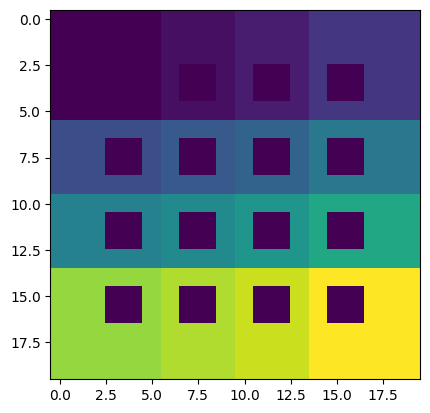

In [61]:
import matplotlib.pyplot as plt
plt.imshow(c[3,:,:])

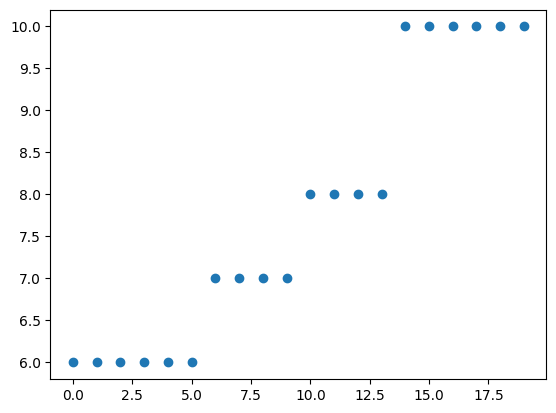

In [64]:
plt.scatter(range(0,20),c[0,7,:])

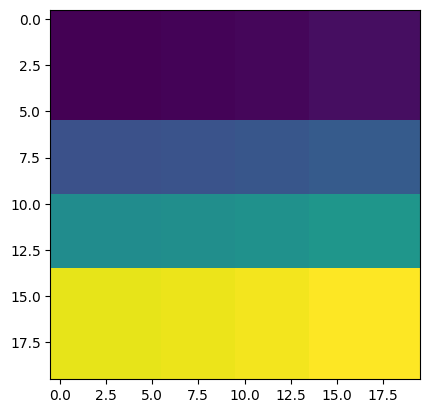

In [62]:
plt.imshow(c[:,5,:])

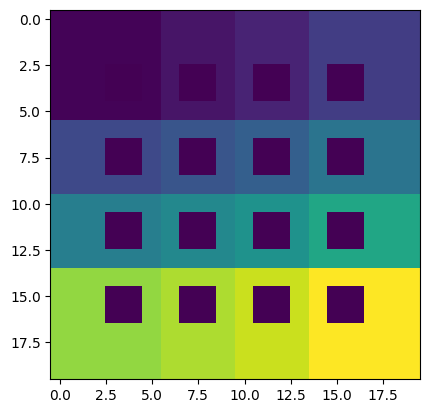

In [63]:
plt.imshow(c[:,:,8])

Working ok